<a href="https://colab.research.google.com/github/edaviesc/Movie-Ratings/blob/main/Movieratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset preview (raw wide format):
  Unnamed: 0  Movie1  Movie2  Movie3  Movie4  Movie5  Movie6  Movie7  Movie8  \
0      User1       0       5       3       1       0       0       0       4   
1      User2       5       3       5       4       1       5       0       0   
2      User3       0       2       0       1       5       0       0       3   
3      User4       5       0       0       0       5       0       2       3   
4      User5       2       0       0       4       2       0       0       2   

   Movie9  ...  Movie41  Movie42  Movie43  Movie44  Movie45  Movie46  Movie47  \
0       2  ...        0        0        0        5        0        2        0   
1       0  ...        0        3        3        1        3        0        1   
2       0  ...        5        0        0        0        0        0        2   
3       0  ...        0        4        5        2        0        0        3   
4       0  ...        5        5        5        0        0        5        0  

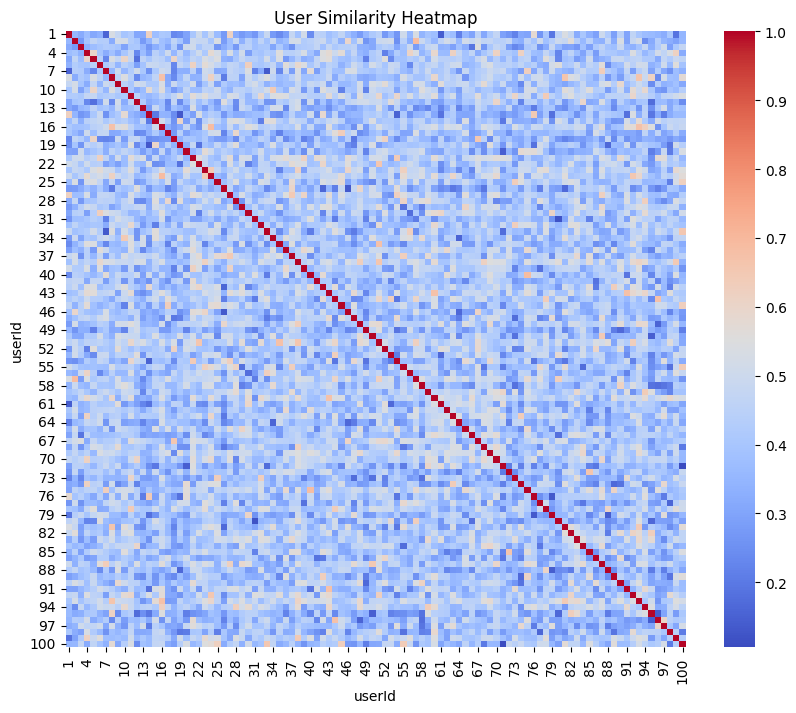


Top Collaborative Recommendations for User 42:
movieId
7     1.875476
3     1.691348
36    1.631864
32    1.630161
37    1.599481
dtype: float64

Top Content-Based (Popularity) Recommendations:
movieId
37    3.340426
45    3.309524
20    3.261905
18    3.212766
36    3.160000
Name: rating, dtype: float64

Comparison:
   Collaborative  Content-Based
0              7             37
1              3             45
2             36             20
3             32             18
4             37             36


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load ratings.csv
# -------------------------------

file_path = "/content/drive/MyDrive/data/ratings.csv"
raw_ratings_wide = pd.read_csv(file_path)

print("Dataset preview (raw wide format):")
print(raw_ratings_wide.head())

# Transform the wide format into a long format (userId, movieId, rating)
# First, rename the user ID column
ratings = raw_ratings_wide.rename(columns={'Unnamed: 0': 'userId'})

# Melt the DataFrame to convert 'MovieX' columns into rows
ratings = ratings.melt(
    id_vars=['userId'],
    var_name='movieId_str',
    value_name='rating'
)

# Extract integer movieId from 'MovieX' string (e.g., 'Movie1' -> 1)
ratings['movieId'] = ratings['movieId_str'].str.replace('Movie', '').astype(int)

# Drop the temporary 'movieId_str' column
ratings = ratings.drop(columns=['movieId_str'])

# Convert userId from 'UserX' to integer X for consistency
ratings['userId'] = ratings['userId'].str.replace('User', '').astype(int)

# Filter out rows where rating is 0, assuming 0 means no rating/unseen movie.
# This is crucial for accurate recommendations.
ratings = ratings[ratings['rating'] != 0]

print("\nTransformed ratings (long format) preview:")
print(ratings.head())

# Now, create user-item matrix from the long format ratings
user_item_matrix = ratings.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
).fillna(0) # Fill NaN with 0 for cosine similarity calculation

print("\nUser-item matrix shape:", user_item_matrix.shape)

# -------------------------------
# 2. User-user similarity matrix
# -------------------------------

user_similarity = cosine_similarity(user_item_matrix)

similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

print("\nSimilarity matrix computed.")

# -------------------------------
# BONUS: Heatmap visualization
# -------------------------------

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap="coolwarm")
plt.title("User Similarity Heatmap")
plt.show()

# -------------------------------
# 3. Collaborative filtering
# -------------------------------

def get_recommendations(user_id, top_n=5):

    # Similar users
    sim_scores = similarity_df[user_id].sort_values(ascending=False)

    # Remove self similarity
    sim_scores = sim_scores.drop(user_id)

    # Weighted ratings
    weighted_scores = np.dot(
        sim_scores.values,
        user_item_matrix.loc[sim_scores.index]
    )

    # Normalize
    weighted_scores /= sim_scores.sum()

    scores = pd.Series(
        weighted_scores,
        index=user_item_matrix.columns
    )

    # Remove already watched movies
    watched = user_item_matrix.loc[user_id]
    scores = scores[watched == 0] # Filter out movies the user has already rated (where rating is 0 in the user-item matrix means unwatched after fillna)

    return scores.sort_values(ascending=False).head(top_n)

# -------------------------------
# 4. Recommendations for User #42
# -------------------------------

user_id = 42

collab_recs = get_recommendations(user_id, 5)

print("\nTop Collaborative Recommendations for User 42:")
print(collab_recs)

# -------------------------------
# 5. Content-based baseline
# -------------------------------
# Simple baseline:
# Recommend highest average-rated unseen movies

movie_avg = ratings.groupby("movieId")["rating"].mean() # 'ratings' is now in long format, so this works.

watched_movies = user_item_matrix.loc[user_id]
# Filter out movies that the user has already rated (where rating in user_item_matrix is > 0)
unwatched_movie_avg = movie_avg[watched_movies == 0]

content_recs = unwatched_movie_avg.sort_values(
    ascending=False
).head(5)

print("\nTop Content-Based (Popularity) Recommendations:")
print(content_recs)

# -------------------------------
# Comparison output
# -------------------------------

print("\nComparison:")
comparison = pd.DataFrame({
    "Collaborative": collab_recs.index,
    "Content-Based": content_recs.index
})

print(comparison)
